# Network Analysis for Information Retrieval - Part 4

Elyes KHALFALLAH & Mohammed Ali EL ADLOUNI

16/03/2025

---

---


In [1]:
# Useful libraries
from fonctions import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import networkx as nx
import ipysigma as sigma
import random
import community.community_louvain as community_louvain
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from scipy.linalg import eigh
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import scipy.sparse as sp


In [2]:
# Load data
data_text = pd.read_csv("data_text.csv")
print(data_text.shape)


(40596, 10)


In [3]:
data_text.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40596 entries, 0 to 40595
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        39980 non-null  object
 1   venue       40596 non-null  object
 2   abstract    18013 non-null  object
 3   authors     40596 non-null  object
 4   n_citation  40596 non-null  int64 
 5   references  27246 non-null  object
 6   title       40596 non-null  object
 7   year        40596 non-null  int64 
 8   id          40596 non-null  object
 9   class       40596 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 3.1+ MB


In [4]:
data_text[:1]


,text,venue,abstract,authors,n_citation,references,title,year,id,class
0,preliminary comprehension school mind school s...,international conference on human-computer int...,The purpose of this study is to develop a lear...,"['Makoto Satoh', 'Ryo Muramatsu', 'Mizue Kayam...",0,"['51c7e02e-f5ed-431a-8cf5-f761f266d4be', '69b6...",Preliminary Design of a Network Protocol Learn...,2013,00127ee2-cb05-48ce-bc49-9de556b93346,3


In [5]:
# When removing stopwords and most common words, some rows may become empty. We need to remove them.
df = data_text.dropna(subset=["text"])
print(df.shape)


(39980, 10)


In [6]:
# Nous allons maintenant construire la matrice Documents x Termes en adoprant le schéma de pondération TF-IDF

# Define the vectorizer
tf_vectorizer = TfidfVectorizer(use_idf=False)
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the vectorizer on the 'text' column
X_tf = tf_vectorizer.fit_transform(df["text"])
X_tfidf = tfidf_vectorizer.fit_transform(df["text"])

# Show the shape of the resulting matrix
X_tfidf.shape


(39980, 54973)

In [7]:
from scipy.sparse import csr_matrix

# Compute sparse adjacency matrix
A = X_tfidf @ X_tfidf.T  # Sparse matrix multiplication
A = csr_matrix(A)  # Ensure it's stored efficiently


In [8]:
num_nodes = X_tfidf.shape[0] 
subset_size = int(num_nodes * 0.3) 
print(num_nodes)
print(subset_size)


39980
11994


In [9]:
# Suppose idx_subset is a list or tensor of indices you want to keep
subset_idx = np.random.choice(num_nodes, subset_size, replace=False)
subset_idx = np.sort(subset_idx)  # Optional, for consistent ordering

# Extract subgraph from the sparse adjacency matrix A (make sure A is in CSR/CSC format)
A_subset = A[subset_idx, :][:, subset_idx]


In [10]:
# Utility function: normalize a sparse adjacency matrix (add self-loops and symmetrically normalize)
def normalize_adj(adj):
    # Add self-loops: A_tilde = A + I
    adj = adj + sp.eye(adj.shape[0])
    # Compute the degree matrix
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    # Return A_norm = D^(-1/2) * A_tilde * D^(-1/2)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()

# Utility function: convert a scipy sparse matrix to a torch sparse tensor
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64)
    )
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


In [11]:
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        if self.bias is not None:
            nn.init.zeros_(self.bias)
    
    def forward(self, input, adj):
        # Utilise torch.spmm si le tenseur d'entrée est sparse, sinon torch.mm
        support = torch.spmm(input, self.weight) if input.is_sparse else torch.mm(input, self.weight)
        output = torch.spmm(adj, support) if adj.is_sparse else torch.mm(adj, support)
        return output + self.bias if self.bias is not None else output

# Définition du modèle GCN
class GCN(nn.Module):
    def __init__(self, n_features, hidden_dim, n_classes):
        super(GCN, self).__init__()
        # Première couche GCN
        self.gc1 = GraphConvolution(n_features, hidden_dim)
        # Deuxième couche GCN (couche de sortie)
        self.gc2 = GraphConvolution(hidden_dim, n_classes)
    
    def forward(self, input, adj):
        # Utilisation des sous-couches définies
        x = F.relu(self.gc1(input, adj))
        x = F.dropout(x, training=self.training)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)


In [12]:
# Normalize the adjacency matrix and convert to a torch sparse tensor
A_subset_norm = normalize_adj(A_subset)
adj_torch = sparse_mx_to_torch_sparse_tensor(A_subset_norm)

# save the adjacency matrix
# torch.save(adj_torch, "adj_torch.pt")


C:\Users\medal\AppData\Local\Temp\ipykernel_5324\1087387160.py:22: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:646.)
  return torch.sparse.FloatTensor(indices, values, shape)


In [13]:
# save the adjacency matrix
# torch.save(adj_torch, "adj_torch.pt")


In [14]:
# adj_torch  = torch.load("adj_torch.pt")


In [15]:
# First, index the SciPy sparse matrix using your subset indices:
X_subset_sparse = X_tfidf[subset_idx]  # This selects the rows corresponding to subset_idx

# Then, convert the submatrix to a PyTorch sparse tensor:
X_subset = sparse_mx_to_torch_sparse_tensor(X_subset_sparse)


In [17]:
labels = torch.LongTensor(df['class'].values)
idx_train = torch.arange(0, int(0.8 * X_tfidf.shape[0]))  # 80% training
idx_test = torch.arange(int(0.8 * X_tfidf.shape[0]), X_tfidf.shape[0])



In [18]:
# Define model hyperparameters
n_features = X_tfidf.shape[1]  # Number of input features
hidden_dim = 16  # for example
n_classes = 8    # adjust based on your actual number of classes

# Initialize the model, loss, and optimizer
model = GCN(n_features, hidden_dim, n_classes)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.NLLLoss()


In [19]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64)
    )
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

X_torch = sparse_mx_to_torch_sparse_tensor(X_tfidf)


In [20]:
X_torch.shape


torch.Size([39980, 54973])

In [21]:
labels_subset = labels[subset_idx]


In [22]:
labels = torch.LongTensor(df['class'].values - 1)


In [23]:
# num_nodes = X_subset.shape[0]
# subset_ratio = 0.01  # e.g., use 10% of nodes for training
# subset_size = int(num_nodes * subset_ratio)
# subset_idx = np.random.choice(num_nodes, subset_size, replace=False)
# idx_train = torch.LongTensor(subset_idx)

# import matplotlib.pyplot as plt

# # Lists to store training metrics
# train_losses = []
# train_accuracies = []

# model.train()
# epochs = 200
# for epoch in range(epochs):
#     optimizer.zero_grad()
#     output = model(X_subset, adj_torch)
    
#     # Compute loss on training nodes
#     loss = criterion(output[idx_train], labels[idx_train])
#     loss.backward()
#     optimizer.step()
    
#     # Record training loss
#     train_losses.append(loss.item())
    
#     # Compute training accuracy on the selected nodes
#     _, preds = torch.max(output[idx_train], 1)
#     correct = torch.sum(preds == labels[idx_train]).item()
#     train_acc = correct / len(idx_train)
#     train_accuracies.append(train_acc)
    
#     # Print performance every 10 epochs
#     if epoch % 10 == 0:
#         print(f"Epoch {epoch:03d} - Loss: {loss.item():.4f} - Train Accuracy: {train_acc:.4f}")

# # Plot training loss curve
# plt.figure(figsize=(10, 5))
# plt.plot(range(epochs), train_losses, label='Training Loss')
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Training Loss Curve")
# plt.legend()
# plt.show()

# # Plot training accuracy curve
# plt.figure(figsize=(10, 5))
# plt.plot(range(epochs), train_accuracies, label='Training Accuracy')
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.title("Training Accuracy Curve")
# plt.legend()
# plt.show()


In [24]:
num_nodes = X_subset.shape[0]
subset_ratio = 0.01  # e.g., use 10% of nodes for training
subset_size = int(num_nodes * subset_ratio)
subset_idx = np.random.choice(num_nodes, subset_size, replace=False)
idx_train = torch.LongTensor(subset_idx)

import matplotlib.pyplot as plt

# Lists to store training metrics
train_losses = []
train_accuracies = []





num_nodes = X_subset.shape[0]

# Select a random subset of nodes from the available subset
# Here, subset_ratio defines what fraction of nodes to use from X_subset.
subset_ratio = 0.01  # for example, 1% of nodes
subset_size = int(num_nodes * subset_ratio)
all_subset_idx = np.random.choice(num_nodes, subset_size, replace=False)

# Split the indices into training and evaluation sets (e.g., 80/20 split)
np.random.shuffle(all_subset_idx)
train_size = int(0.8 * subset_size)
train_idx = all_subset_idx[:train_size]
eval_idx = all_subset_idx[train_size:]

# Convert indices to torch LongTensors
idx_train = torch.LongTensor(train_idx)
idx_eval = torch.LongTensor(eval_idx)

# -----------------------------
# Training Loop
# -----------------------------
# Lists to store training metrics
train_losses = []
train_accuracies = []

model.train()
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(X_subset, adj_torch)
    
    # Compute loss on training nodes
    loss = criterion(output[idx_train], labels[idx_train])
    loss.backward()
    optimizer.step()
    
    # Record training loss
    train_losses.append(loss.item())
    
    # Compute training accuracy on the selected nodes
    _, preds = torch.max(output[idx_train], 1)
    correct = torch.sum(preds == labels[idx_train]).item()
    train_acc = correct / len(idx_train)
    train_accuracies.append(train_acc)
    
    # Print performance every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} - Loss: {loss.item():.4f} - Train Accuracy: {train_acc:.4f}")





Epoch 000 - Loss: 2.0792 - Train Accuracy: 0.1263
Epoch 010 - Loss: 1.8871 - Train Accuracy: 0.2947
Epoch 020 - Loss: 1.7930 - Train Accuracy: 0.2947
Epoch 030 - Loss: 1.6766 - Train Accuracy: 0.4105
Epoch 040 - Loss: 1.5519 - Train Accuracy: 0.4842
Epoch 050 - Loss: 1.4065 - Train Accuracy: 0.5789
Epoch 060 - Loss: 1.2767 - Train Accuracy: 0.6316
Epoch 070 - Loss: 1.1393 - Train Accuracy: 0.7263
Epoch 080 - Loss: 1.0250 - Train Accuracy: 0.8105
Epoch 090 - Loss: 0.9169 - Train Accuracy: 0.8105
Epoch 100 - Loss: 0.8165 - Train Accuracy: 0.8526
Epoch 110 - Loss: 0.7677 - Train Accuracy: 0.8737
Epoch 120 - Loss: 0.6997 - Train Accuracy: 0.8737
Epoch 130 - Loss: 0.6808 - Train Accuracy: 0.8842
Epoch 140 - Loss: 0.6340 - Train Accuracy: 0.8737
Epoch 150 - Loss: 0.6051 - Train Accuracy: 0.9158
Epoch 160 - Loss: 0.5497 - Train Accuracy: 0.9263
Epoch 170 - Loss: 0.5791 - Train Accuracy: 0.8737
Epoch 180 - Loss: 0.5428 - Train Accuracy: 0.9579
Epoch 190 - Loss: 0.5213 - Train Accuracy: 0.9368


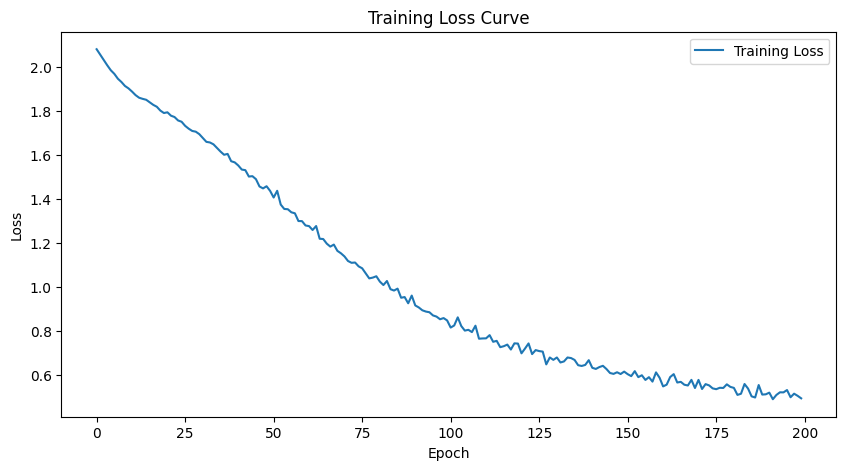

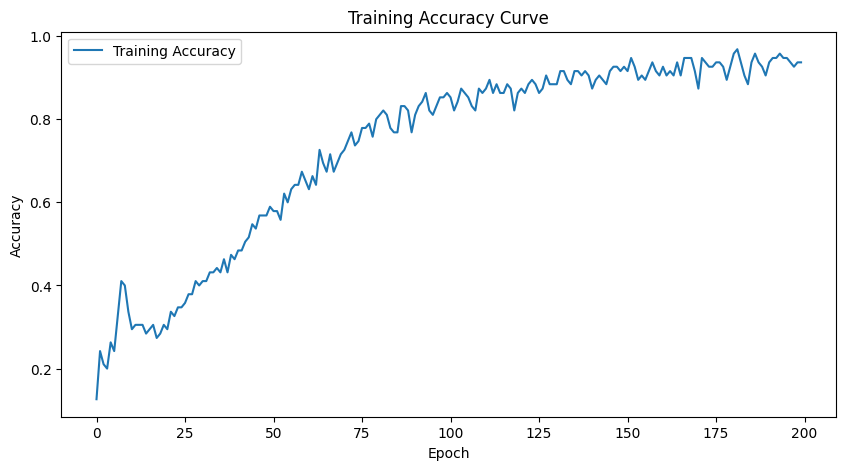

In [27]:
# Plot training loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

# Plot training accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_accuracies, label='Training Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Curve")
plt.legend()
plt.show()



In [28]:
# -----------------------------
# Evaluation
# -----------------------------
model.eval()
with torch.no_grad():
    output = model(X_subset, adj_torch)
    # Get predictions: choose the class with the highest log-probability
    pred = output.argmax(dim=1)
    # Compare predictions against labels for evaluation nodes
    correct = pred[idx_eval].eq(labels[idx_eval]).sum().item()
    accuracy = correct / idx_eval.shape[0]
    print(f"Evaluation Accuracy: {accuracy:.4f}")


Evaluation Accuracy: 0.3333
